In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot
    
tf.__version__

Using TensorFlow backend.


'1.13.1'

### Getting data from csv

In [2]:
filename = "cleaned_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 299 entries, PTID to DX_bl
dtypes: float64(148), int64(148), object(3)
memory usage: 334.1+ KB
None


,PTID,scandate,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,936,1.984,1158,2.107,993,2.306,1226,2.359,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,855,2.160,1291,2.287,1137,1.961,1451,2.059,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,849,2.122,909,2.272,788,2.430,717,2.606,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,762,2.237,969,2.141,1153,2.130,1156,2.135,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,752,2.073,960,2.521,873,2.374,810,2.481,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


**Should do some form of test train split**

We'll start with a (stratified) shuffle split for now. Startified sampling ensures that **test** set has the correct representation of each category.

Later move on to K-Folds to really test out the network...

# IDEAS

## How about make it CN vs AD only


### How about we fuse some of the classes - wont reduce samples
> NC = NC + SMC -> just fuse them 

> MCI = EMCI + LMCI

> AD

### Try removing SA from the features
> Just keep Thickness

#### Add hippocampus volumes L and R
> from aseg.stat

> Also add up all volumes in aseg.stat and add up to get ICV intra cranial volume

### Instead could normalize the thickness by ICV (divide them by ICV value)
> Note that ICV = mm^3 and thickness = mm, so divide by ICV^(1/3)


### > Balancing the training set -> SMOTE
- look at scikit learn, scipy
- just do it in feature space
- will interpolate samples to balance the classes


### ANOTHER approach is to ** pretrain ** if nothing else works
- Pretrain on all 600 samples
- Freeze all but the last two layers and retrain on 143 dataset
- Make sure that test set is never seen, eevn in pretraining

In [3]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate",label_col])
raw_labels = raw_data[label_col].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [4]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.head()

,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_TH_lh,G_and_S_cingul-Ant_TH_lh,G_and_S_cingul-Mid-Ant_TH_lh,G_and_S_cingul-Mid-Post_TH_lh,G_cingul-Post-dorsal_TH_lh,G_cingul-Post-ventral_TH_lh,...,S_parieto_occipital_TH_rh,S_pericallosal_TH_rh,S_postcentral_TH_rh,S_precentral-inf-part_TH_rh,S_precentral-sup-part_TH_rh,S_suborbital_TH_rh,S_subparietal_TH_rh,S_temporal_inf_TH_rh,S_temporal_sup_TH_rh,S_temporal_transverse_TH_rh
0,1.984,2.107,2.306,2.359,2.338,2.185,2.351,2.294,2.656,2.034,...,1.836,2.148,1.731,2.309,1.984,1.421,1.937,1.759,2.025,1.579
1,2.160,2.287,1.961,2.059,2.207,2.371,2.121,1.987,2.289,2.060,...,1.692,1.832,1.589,2.189,1.861,2.457,1.804,1.970,2.071,1.642
2,2.122,2.272,2.430,2.606,2.456,2.541,2.580,2.276,2.578,2.291,...,1.977,2.623,1.882,2.192,2.071,2.222,1.870,1.826,2.056,2.179
3,2.237,2.141,2.130,2.135,2.282,2.218,2.213,2.332,2.985,2.224,...,1.749,2.065,1.882,2.071,2.104,2.880,2.245,1.924,2.014,1.826
4,2.073,2.521,2.374,2.481,2.331,2.854,2.854,2.533,3.032,2.412,...,2.118,2.887,1.862,2.146,2.238,3.412,2.276,2.535,2.168,2.166


In [5]:
raw_labels.value_counts()/len(raw_labels)

EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

## Fusing all the columns

In [6]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x
dist = lambda x: pd.Series(x).value_counts()/len(x)

fused_labels = list(map(fuse, raw_labels))

In [7]:
print("Sample Size:", len(fused_labels))
dist(fused_labels)

Sample Size: 143


MCI    0.468531
CN     0.349650
AD     0.181818
dtype: float64

## Getting rid of MCI samples
> Only learning CN vs AD

In [8]:
labels = pd.Series(fused_labels)
non_MCI_samples = labels != "MCI"

stripped_features = raw_features[non_MCI_samples]
stripped_labels = labels[non_MCI_samples]

dist(stripped_labels)

CN    0.657895
AD    0.342105
dtype: float64

## Using SMOTE

> Generates interpolated samples to balance training data 

In [9]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

features, labels = sm.fit_resample(stripped_features, stripped_labels)

print(features.shape)
print(pd.Series(labels).value_counts()/len(labels))
len(labels)

(100, 148)
CN    0.5
AD    0.5
dtype: float64


100

### Get 1 Hot Vector representation of the *fused* categorical labels

In [10]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
labels_1hot = enc.fit_transform([[label] for label in labels]) # Since the function expects an array of "features" per sample

print("Categories:", enc.categories_)

print(labels[:5])
print(len(labels))
labels_1hot[:5]

Categories: [array(['AD', 'CN'], dtype=object)]
['CN' 'CN' 'AD' 'AD' 'CN']
100


array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, labels):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]

In [13]:
print("Train Size:", X_train.shape)
# print(y_test_1hot)

Train Size: (80, 148)


### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [54]:
from keras import optimizers
from keras import regularizers

def build_dnn(num_features, num_labels=2):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 150, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 150, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.2))
    
    dnn.add(Dense(units=num_labels, activation="softmax")) # 5 labels -> logits for now

    dnn.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    return dnn

dnn = build_dnn(X_train.shape[1])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               22350     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [55]:
dnn = build_dnn(X_train.shape[1])
history = dnn.fit(X_train, y_train_1hot, epochs=30, batch_size = 20, validation_data=(X_test, y_test_1hot))

Train on 90 samples, validate on 10 samples
Epoch 1/30
90/90 [==============================] - 0s 5ms/step - loss: 13.7029 - acc: 0.5778 - val_loss: 12.6662 - val_acc: 0.7000
Epoch 2/30
90/90 [==============================] - 0s 115us/step - loss: 12.7865 - acc: 0.6556 - val_loss: 12.7084 - val_acc: 0.7000
Epoch 3/30
90/90 [==============================] - 0s 120us/step - loss: 12.2070 - acc: 0.8111 - val_loss: 12.5823 - val_acc: 0.7000
Epoch 4/30
90/90 [==============================] - 0s 120us/step - loss: 12.5397 - acc: 0.7667 - val_loss: 12.4240 - val_acc: 0.7000
Epoch 5/30
90/90 [==============================] - 0s 134us/step - loss: 12.3908 - acc: 0.6889 - val_loss: 12.1448 - val_acc: 0.8000
Epoch 6/30
90/90 [==============================] - 0s 121us/step - loss: 12.1370 - acc: 0.8333 - val_loss: 11.7085 - val_acc: 0.8000
Epoch 7/30
90/90 [==============================] - 0s 119us/step - loss: 11.8555 - acc: 0.8111 - val_loss: 11.4090 - val_acc: 0.9000
Epoch 8/30
90/90 [==

In [140]:
# df = pd.DataFrame(history.history)
# print(max(df["val_acc"]))
# df[["acc","val_acc"]].plot(figsize=(12,8))

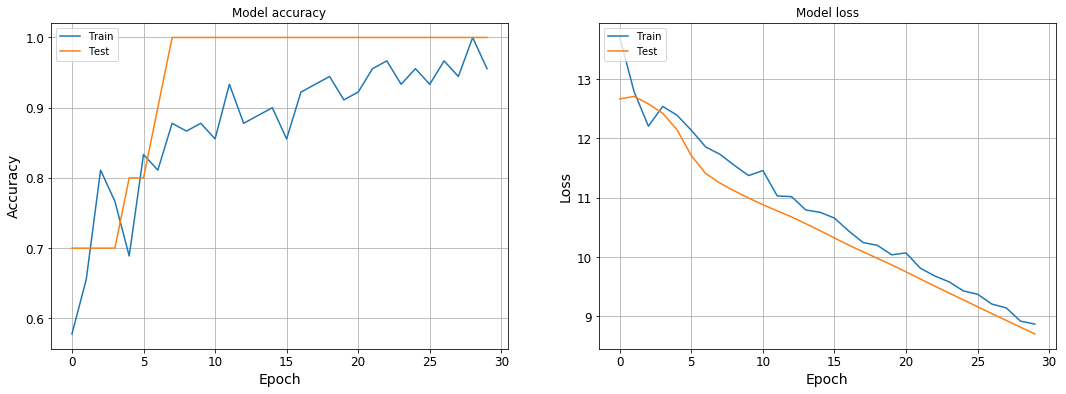

In [139]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(18,6))
    
    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    
    plt.show()

plot_history(history)

In [96]:
loss_and_metrics = dnn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

41/41 [==============================] - 0s 83us/step
Scores on test set: loss=1.418 accuracy=0.7317


In [97]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

201/201 [==============================] - 0s 36us/step
Scores on test set: loss=4.067 accuracy=0.3433


In [87]:
features.shape

(100, 148)

## Using K=10 Fold Cross Validation

In [39]:
def getKF(X,y, n_splits=10):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits) #Default = 10

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        yield X_train, y_train, X_test, y_test, test_index

histories = []
testing_indxs =[]
zoo = []
for X_train, y_train_1hot, X_test, y_test_1hot, test_index in getKF(features, labels_1hot):
    dnn = build_dnn(X_train.shape[1])
    history = dnn.fit(X_train, y_train_1hot, epochs=30, batch_size = 20, validation_data=(X_test, y_test_1hot), verbose=0)
    histories.append(history)
    testing_indxs.append(test_index)
    zoo.append(dnn)
    print(history.history["acc"][-1], history.history["val_acc"][-1])

0.9888888862397935 0.800000011920929
0.9888888862397935 0.800000011920929
0.9888888862397935 1.0
0.9666666587193807 0.8999999761581421
0.9555555449591743 0.8999999761581421
0.9666666587193807 0.8999999761581421
0.9888888862397935 0.8999999761581421
0.9888888862397935 0.800000011920929
0.9666666587193807 1.0
0.933333330684238 1.0


In [34]:
len(histories)

10

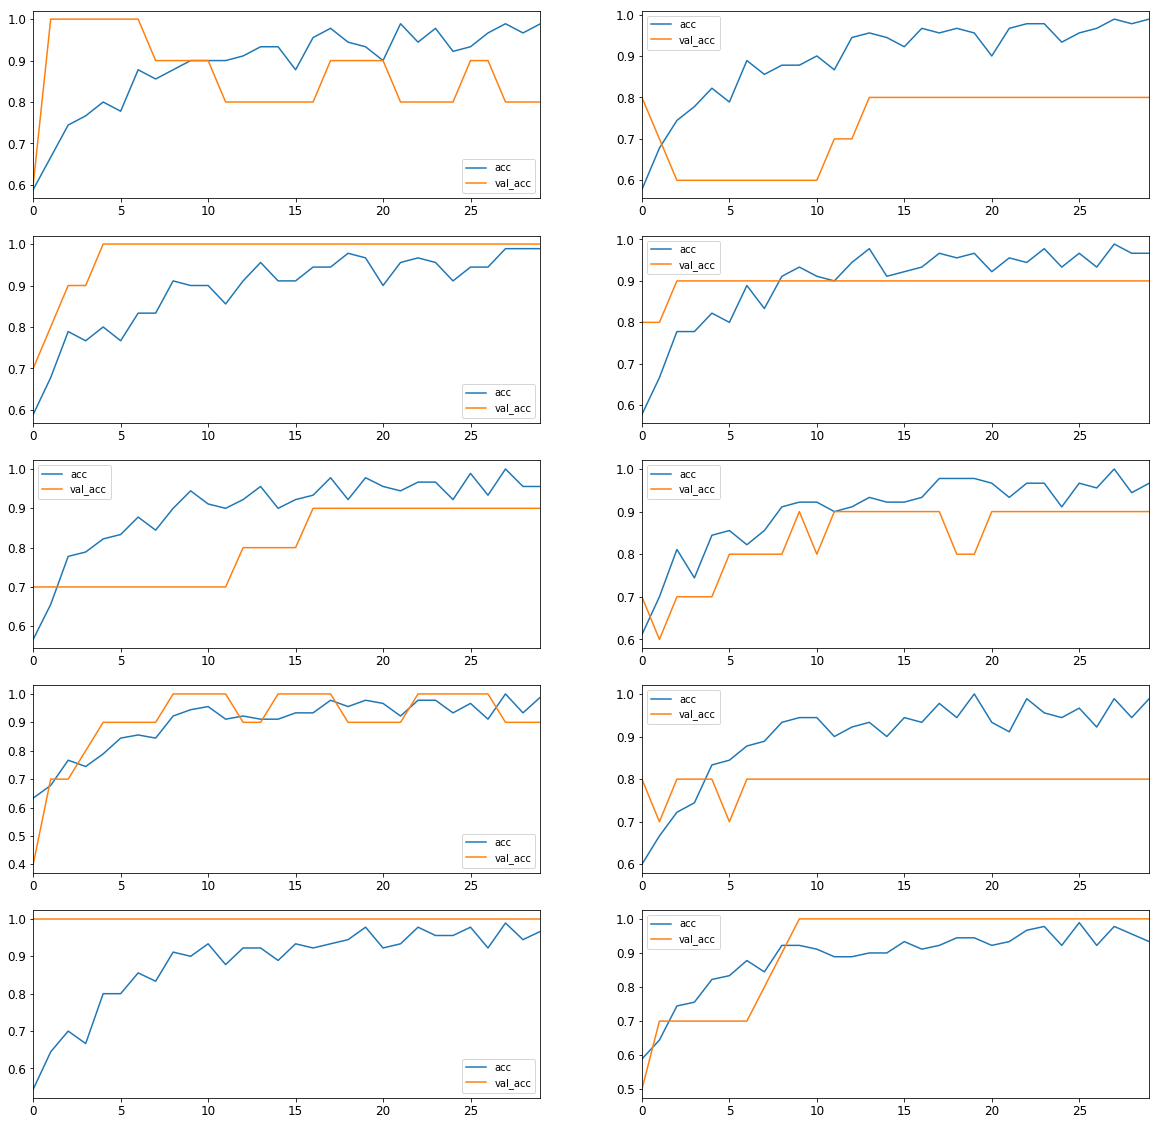

In [40]:
fig, axs = plt.subplots(len(histories)//2,2, figsize=(20,20))
axs=axs.flatten()
dfs = []

for i,history in enumerate(histories):
    df = pd.DataFrame(history.history)
    dfs.append(df)
    df[["acc","val_acc"]].plot(ax=axs[i])

Average: 0.8999999940395356


[0.800000011920929,
 0.800000011920929,
 1.0,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421,
 0.800000011920929,
 1.0,
 1.0]

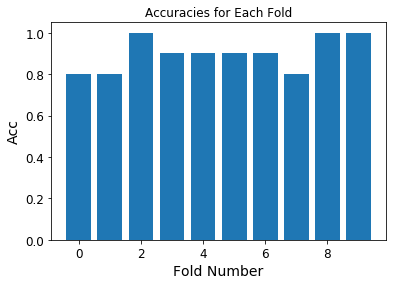

In [45]:
val_accs = [df["val_acc"].iloc[-1] for df in dfs]

print("Average:",np.mean(val_accs))
plt.bar(x=range(10),height=val_accs)
# plt.scatter(x=range(10), y=np.mean(val_accs))
plt.xlabel("Fold Number")
plt.ylabel("Acc")
plt.title("Accuracies for Each Fold")
val_accs

In [94]:
testing_indxs

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]

# Evaluating on non SMOTE Samples

In [113]:
# def get_correct_predictions(model,X,y):
samples = scaler.fit_transform(stripped_features) # Note that features is no longer a dataframe

hot_enc = OneHotEncoder(categories="auto", sparse=False)
sample_labels = hot_enc.fit_transform([[label] for label in stripped_labels])
print("Categories:", enc.categories_)

predictions = model.predict(samples)
preds = np.array([np.argmax(x) for x in predictions])
correct = np.array([np.argmax(x) for x in sample_labels])
test_idxs = preds == correct
correct == 1

Categories: [array(['AD', 'CN'], dtype=object)]


array([ True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [104]:
loss_and_metrics = model.evaluate(samples, sample_labels)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

76/76 [==============================] - 0s 59us/step
Scores on test set: loss=8.723 accuracy=1.0000


# LRP

In [115]:
import innvestigate
import innvestigate.utils as iutils


def perform_analysis(model, analyzer, data, labels):
    analysis = analyzer.analyze(data)
    prediction = model.predict(data)
    
    header = "{:^30} {} {}".format("Relevances","Pred", "Actual")
    print(header)
    
    for rel,pred,actual in zip(analysis,prediction, labels):
#         print(np.argmax(pred), actual)
        result = "{} {:d} {:d}".format(np.around(rel,4), np.argmax(pred), np.argmax(actual))
        print(result)
    df_anal = pd.DataFrame(analysis)
    print()
#     print(df_anal.describe())
    return df_anal

# Selecting a DNN
test_dnn = dnn#zoo[2]

# Getting population to analyze
# Select samples with correct prediction
test_idx = correct == 1    #get_correct_predictions() 
test_samples = samples[test_idx] #features[test_idx]
test_labels = sample_labels[test_idx] #labels_1hot[test_idx]

# Stripping the softmax activation from the model
model_wo_sm = iutils.keras.graph.model_wo_softmax(test_dnn)

# Creating an analyzer
gradient_analyzer = innvestigate.analyzer.Gradient(model_wo_sm)
lrp = innvestigate.create_analyzer("lrp.z", model_wo_sm)


# perform_analysis(nn,gradient_analyzer,flowers,types)
lrp_results = perform_analysis(dnn,lrp,test_samples, test_labels)

          Relevances           Pred Actual
[ 0.0023  0.0666  0.445  -0.3415  0.1108  0.121   0.1879  0.0119 -0.104
  0.2638 -0.1572 -0.0785 -0.2328  0.1779  0.002  -0.0765  0.0494  0.0273
 -0.0401 -0.2973  0.1922  0.0085  0.2568  0.0065 -0.0065  0.0375 -0.0046
  0.1081  0.2754 -0.0164 -0.1046 -0.2859 -0.071   0.0422  0.3778  0.0769
 -0.0931  0.0742  0.1514  0.005  -0.0198 -0.0513  0.1722  0.1854 -0.1418
  0.0055 -0.0063  0.0162 -0.0491 -0.0182  0.0389  0.0112 -0.0158 -0.1259
 -0.106   0.0011 -0.     -0.0328  0.0379 -0.022  -0.0134 -0.0942  0.0379
  0.0158  0.1112 -0.2214  0.0018 -0.0297 -0.0584  0.0318 -0.1549 -0.0038
 -0.0647 -0.8543 -0.0606  0.0029  0.1636  0.0247 -0.0356 -0.014   0.0705
 -0.1639 -0.0155  0.026  -0.0744  0.0097  0.0178 -0.171   0.0221  0.0383
 -0.1555 -0.0039 -0.0033  0.2639 -0.0098  0.021   0.9873 -0.0473  0.152
  0.0658 -0.1755 -0.0689 -0.4003  0.0277  0.0415 -0.3413 -0.3259 -0.0299
  0.2916 -0.0258 -0.0742 -0.0323  0.2406 -0.0908  0.0025  0.0093  0.2165
 -0.1014 -

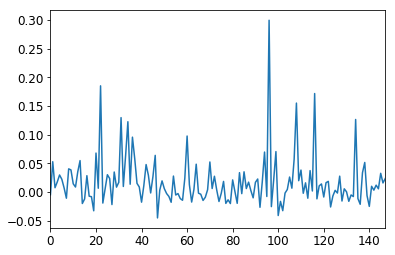

In [116]:
population = lrp_results.mean()
population.plot()

In [122]:
best_features = population.sort_values(ascending=False)[:5]

In [124]:
best_features.index

Int64Index([96, 22, 116, 108, 31], dtype='int64')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14955d7b8>,
      dtype=object)

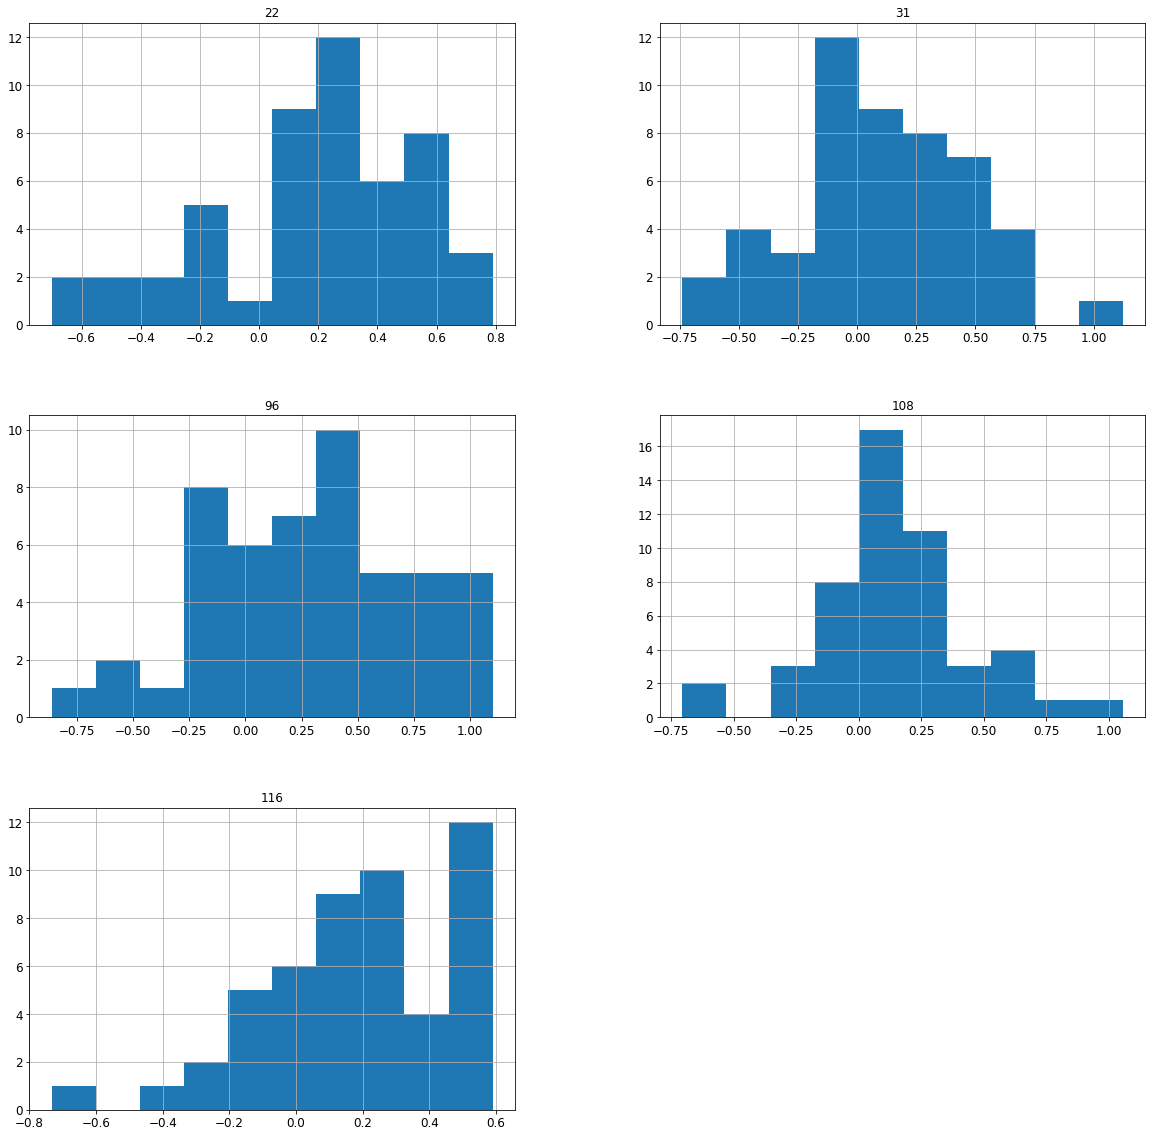

In [128]:
lrp_results[best_features.index].hist(figsize=(20,20))

In [129]:
raw_features.columns[best_features.index]

Index(['G_oc-temp_med-Parahip_TH_rh', 'G_oc-temp_med-Parahip_TH_lh',
       'Pole_temporal_TH_rh', 'G_temp_sup-Plan_polar_TH_rh',
       'G_subcallosal_TH_lh'],
      dtype='object')